In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
import math
from sklearn.metrics import mean_squared_error
import pandas_datareader as dr
import datetime as dt

In [2]:
# Loding Financial dataset
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2014,9,17)
end = dt.datetime.now()

df = dr.DataReader(f'{crypto_currency}-{against_currency}','yahoo',start,end)

In [3]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2022-11-23,16638.193359,16170.502930,16195.588867,16610.707031,3.295888e+10,16610.707031
2022-11-24,16771.474609,16501.767578,16611.636719,16604.464844,2.612904e+10,16604.464844
2022-11-25,16603.316406,16388.404297,16602.269531,16521.841797,1.867826e+10,16521.841797


(2994,)


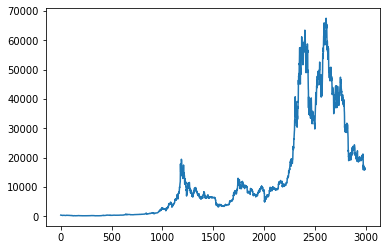

In [4]:
df1 = df.reset_index()['Close']
print(df1.shape)
plt.plot(df1)

In [5]:
# Scaling
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1.shape)

(2994, 1)


In [6]:
# Splittting the dataset
training_size = int(len(df1)*0.65)
test_size = int(len(df1)) - training_size
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1):1]
print(train_data.shape)
print(test_data.shape)

(1946, 1)
(1048, 1)


In [7]:
def create_dataset(dataset, time_step = 1):
    datax, datay = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        datax.append(a)
        datay.append(dataset[i+time_step,0])
    return np.array(datax),np.array(datay)

In [8]:
time_step = 100
x_train, y_train = create_dataset(train_data,time_step)
x_test, y_test = create_dataset(test_data,time_step)

In [9]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((1845, 100), (1845,), (947, 100), (947,))

In [10]:
# reshape input into 3d before giving to LSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [11]:
# Creating stacked LSTM Model
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape =(100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss ='mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train,y_train,validation_data = (x_test,y_test), epochs= 100, batch_size = 64, verbose =1)

Epoch 1/100
29/29 [==============================] - 25s 442ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 2/100
29/29 [==============================] - 8s 290ms/step - loss: 2.1819e-04 - val_loss: 0.0053
Epoch 3/100
29/29 [==============================] - 8s 287ms/step - loss: 1.5589e-04 - val_loss: 0.0061
Epoch 4/100
29/29 [==============================] - 8s 265ms/step - loss: 1.4058e-04 - val_loss: 0.0116
Epoch 5/100
29/29 [==============================] - 8s 284ms/step - loss: 1.2385e-04 - val_loss: 0.0106
Epoch 6/100
29/29 [==============================] - 8s 294ms/step - loss: 1.2266e-04 - val_loss: 0.0130
Epoch 7/100
29/29 [==============================] - 9s 317ms/step - loss: 1.0980e-04 - val_loss: 0.0150
Epoch 8/100
29/29 [==============================] - 9s 325ms/step - loss: 1.0459e-04 - val_loss: 0.0169
Epoch 9/100
29/29 [==============================] - 9s 311ms/step - loss: 9.2382e-05 - val_loss: 0.0197
Epoch 10/100
29/29 [==============================] - 9s 3

In [ ]:
# Let's do the prediction
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [ ]:
# transform to orignal form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Calculating RMSE performance metrices
print("Train Error :",math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test Error :",math.sqrt(mean_squared_error(y_test,test_predict)))

In [ ]:
# Plotting
# shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

# Shift test prediction for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict

# plt baseline and prediction
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
x_input = test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
# prediction for future 30 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [ ]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)